# This is the pipeline using only libraries

In [2]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import models as m
import utils as u
import pandas as pd
from surprise.dataset import * 
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import GridSearchCV
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [416]:
raw_data = pd.read_csv('data/data_train.csv', header=0, index_col=0, names=['Id', 'rating'])

dataFrame = u.preprocess(raw_data).reset_index().drop(columns=['Id'])

# Data Analysis

In [118]:
x = dataFrame.groupby("user").count().rating
x.head()

user
1     20
2    132
3     80
4     20
5    119
Name: rating, dtype: int64

Text(0,0.5,'Number of users')

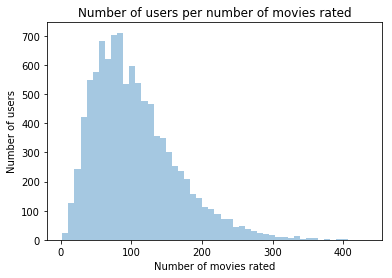

In [125]:
import seaborn as sns 
sns.distplot(x, kde=False);
plt.title('Number of users per number of movies rated')
plt.xlabel('Number of movies rated')
plt.ylabel('Number of users')

In [119]:
y = dataFrame.groupby("item").count().rating
y.head()

item
1     340
2     531
3     792
4    3164
5    1243
Name: rating, dtype: int64

Text(0,0.5,'Number of movie')

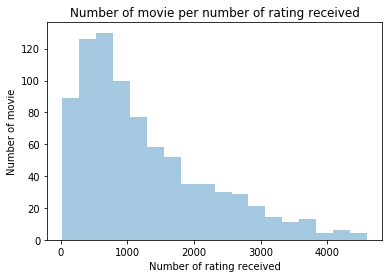

In [127]:
import seaborn as sns 
sns.distplot(y, kde=False);
plt.title('Number of movie per number of rating received')
plt.xlabel('Number of rating received')
plt.ylabel('Number of movie')

Text(0,0.5,'Number of rating')

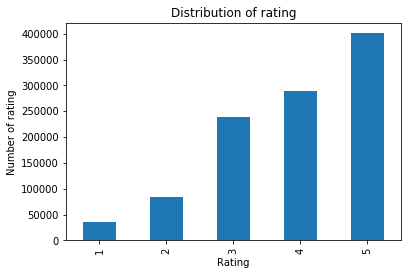

In [122]:
dataFrame.groupby('rating').count().user.plot.bar()
plt.title('Distribution of rating')
plt.xlabel('Rating')
plt.ylabel('Number of rating')

In [418]:
reader=Reader(rating_scale=(1.0,5.0))
formatted_data= Dataset.load_from_df(dataFrame[['user','item','rating']],reader)


## Baseline

In [ ]:
from surprise import BaselineOnly

# bsl_options = {'method': 'als',
#                'n_epochs': 5,
#                'reg_u': 12,
#                'reg_i': 5
#                }
# algoBL = BaselineOnly(bsl_options)
# cross_validate(algoBL, formatted_data, verbose=True,cv=5, measures=['RMSE', 'MAE'])

param_grid = {'bsl_options': {'method': ['sgd','als'],
                               'n_epochs': [5,10],
                               'reg_u': [5,15],
                               'reg_i': [5,15]
                               }
              }

gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
bsl_options=gs.best_params['rmse'].get('bsl_options')
# {'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}, 'verbose': True}

In [419]:
bsl_options= {'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}
algoBL = BaselineOnly(bsl_options)
cross_validate(algoBL, formatted_data, verbose=True,cv=5, measures=['RMSE'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9870  0.9956  0.9926  0.9901  0.9913  0.9913  0.0028  
Fit time          2.92    2.85    3.01    3.81    3.05    3.13    0.35    
Test time         1.13    0.96    0.94    3.32    1.00    1.47    0.93    


{'test_rmse': array([0.9869675 , 0.99560053, 0.9926459 , 0.9900955 , 0.99128126]),
 'fit_time': (2.917841911315918,
  2.846405267715454,
  3.0086100101470947,
  3.8072359561920166,
  3.0451438426971436),
 'test_time': (1.1283760070800781,
  0.9572129249572754,
  0.9413418769836426,
  3.3152878284454346,
  1.0045089721679688)}

In [422]:
ids, preds = u.predict_on_model(algoBL)
u.create_csv_submission(ids, preds, "submissionBase1.csv")

In [365]:
trainset, testset = train_test_split(formatted_data, test_size=.2)

y_val = []
for a,b,c  in testset:
    y_val.append(c)
df_y_val=pd.DataFrame(y_val)


bsl_options={'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}

print("-Training Baseline")
algoBL=BaselineOnly(bsl_options=bsl_options)
algoBL.fit(trainset)

test_predBL=algoBL.test(testset)
dfBL=df_from_model_pred(test_predBL)

-Training Baseline
Estimating biases using als...


## CoClustering

In [385]:
from surprise import CoClustering

# algoCC = m.co_clustering()

# cross_validate(algoCC, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# RMSE: 0.99 locally, 1.140 online

param_grid = {'n_cltr_u':[2,3,4,5],'n_cltr_i': [2,3,4, 5]}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
# best RMSE parameters
print(gs.best_params['rmse'])
n_cltr_u,n_cltr_i=gs.best_params['rmse'].values()

# {'n_cltr_u': 2, 'n_cltr_i': 4}
# 4    138653
# 3     44228
# 5     24801
# 2      2007
# 1        26


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.9991682478951182
{'n_cltr_u': 2, 'n_cltr_i': 4}


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 12.1min finished


In [398]:
algoCC=CoClustering(n_cltr_u=n_cltr_u, n_cltr_i=n_cltr_i)
cross_validate(algoCC, formatted_data, verbose=True,cv=3, measures=['RMSE'])# RMSE: 0.99 locally, 1.140 online


Evaluating RMSE of algorithm CoClustering on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9983  1.0006  1.0013  1.0001  0.0013  
Fit time          16.19   18.30   17.27   17.25   0.86    
Test time         27.27   1.94    1.95    10.39   11.94   


{'test_rmse': array([0.99828744, 1.00062891, 1.00131232]),
 'fit_time': (16.188231945037842, 18.298757791519165, 17.26529622077942),
 'test_time': (27.270771980285645, 1.9414520263671875, 1.9528579711914062)}

In [401]:
ids, preds = u.predict_on_model(algoCC)
u.create_csv_submission(ids, preds, "submissionCoClusteringInv2.csv")

## SVD

In [390]:
from surprise import SVD


# algo = SVD(n_factors=1000, n_epochs=20, lr_all=0.005,reg_all=0.02)
# cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# FOUND RMSE: 1.0276 locally


param_grid = {'n_factors':[800,1000,1200],'n_epochs': [5, 10,20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4], 'verbose':[True]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 0.994 locally, 1.06 online
# (n_factors=20, n_epochs=20, lr_all=0.002,reg_bu=0.1, reg_bi=0.01)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 340.1min finished


0.9981218886886397
{'n_factors': 800, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.2, 'verbose': True}


In [430]:
algoSVD = SVD(n_factors=20, n_epochs=20, lr_all=0.002,reg_bu=0.1, reg_bi=0.01)
cross_validate(algoSVD, formatted_data, verbose=True,cv=3, measures=['RMSE'])# FOUND RMSE: 1.0276 locally

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9973  0.9992  0.9976  0.9980  0.0008  
Fit time          489.00  494.78  489.83  491.20  2.55    
Test time         6.65    2.83    2.84    4.11    1.80    


{'test_rmse': array([0.99731563, 0.99918901, 0.99760937]),
 'fit_time': (489.00414538383484, 494.776967048645, 489.8258008956909),
 'test_time': (6.650759935379028, 2.8321950435638428, 2.839428186416626)}

In [432]:
ids, preds = u.predict_on_model(algoSVD)
u.create_csv_submission(ids, preds, "submissionSVD2.csv")

In [433]:
ids

['r37_c1',
 'r73_c1',
 'r156_c1',
 'r160_c1',
 'r248_c1',
 'r256_c1',
 'r284_c1',
 'r400_c1',
 'r416_c1',
 'r456_c1',
 'r474_c1',
 'r495_c1',
 'r515_c1',
 'r518_c1',
 'r521_c1',
 'r559_c1',
 'r596_c1',
 'r614_c1',
 'r621_c1',
 'r661_c1',
 'r697_c1',
 'r710_c1',
 'r713_c1',
 'r732_c1',
 'r807_c1',
 'r824_c1',
 'r926_c1',
 'r951_c1',
 'r1000_c1',
 'r1141_c1',
 'r1146_c1',
 'r1157_c1',
 'r1184_c1',
 'r1248_c1',
 'r1258_c1',
 'r1283_c1',
 'r1293_c1',
 'r1309_c1',
 'r1377_c1',
 'r1434_c1',
 'r1494_c1',
 'r1540_c1',
 'r1600_c1',
 'r1634_c1',
 'r1678_c1',
 'r1691_c1',
 'r1788_c1',
 'r1803_c1',
 'r1822_c1',
 'r1922_c1',
 'r1935_c1',
 'r1939_c1',
 'r1985_c1',
 'r2068_c1',
 'r2096_c1',
 'r2102_c1',
 'r2192_c1',
 'r2227_c1',
 'r2232_c1',
 'r2236_c1',
 'r2274_c1',
 'r2278_c1',
 'r2280_c1',
 'r2289_c1',
 'r2322_c1',
 'r2331_c1',
 'r2332_c1',
 'r2395_c1',
 'r2405_c1',
 'r2458_c1',
 'r2478_c1',
 'r2489_c1',
 'r2581_c1',
 'r2641_c1',
 'r2713_c1',
 'r2743_c1',
 'r2760_c1',
 'r2787_c1',
 'r2822_c1',
 'r

## SVD++

In [ ]:
from surprise import SVDpp


# algo = SVDpp(verbose=True)
# cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# FOUND RMSE: 1.0188 locally, 1.179 online


param_grid = {'n_factors':[800,1000,1200],'n_epochs': [10,20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4], 'verbose':[True]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


In [11]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionSVDpp.csv")

## NMF

In [392]:
from surprise import NMF

param_grid = {'n_factors':[15,30],'n_epochs': [20,50], 'reg_pu': [0.02, 0.06],'reg_qi': [0.02, 0.06],'reg_bu': [0.02, 0.06],'reg_bi': [0.02, 0.06]}
algo = NMF(verbose=True)
# cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# FOUND RMSE: 1.0089 locally, 1.142 online

gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 1.0084120457123176
# {'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0.06, 'reg_qi': 0.06, 'reg_bu': 0.02, 'reg_bi': 0.06}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.1min


1.0084120457123176
{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0.06, 'reg_qi': 0.06, 'reg_bu': 0.02, 'reg_bi': 0.06}


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 82.3min finished


In [9]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionNMF.csv")

## KNN on Movie

In [374]:
#use 60
from surprise import KNNBasic


algo =m.movie_knn()
cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE']) # FOUND RMSE: 1.0603 locally, 1.133 online

# param_grid = {'n_neighbors':[60,100,300],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6],
#               'sim_options':     {
#       'name': ['pearson'],
#       'user_based': [False],
#       'min_support': [10,100]  #minimum number of common use/item to be compared. 
#     }}
# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)

# # best RMSE score
# print(gs.best_score['rmse'])

# 1.0604891683598427
# {'n_neighbors': 60, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4, 'sim_options': {'name': 'pearson', 'user_based': False, 'min_support': 10}}
# 4    179645
# 3     27298
# 5      2422
# 2       350

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0606  1.0603  1.0597  1.0602  0.0004  
MAE (testset)     0.8721  0.8719  0.8723  0.8721  0.0001  
Fit time          6.60    6.67    6.73    6.66    0.05    
Test time         64.06   92.14   57.92   71.37   14.89   


{'test_rmse': array([1.06063904, 1.06030362, 1.05971643]),
 'test_mae': array([0.87213414, 0.87191787, 0.87226417]),
 'fit_time': (6.597089052200317, 6.665050983428955, 6.730401992797852),
 'test_time': (64.05997896194458, 92.13809585571289, 57.924659967422485)}

In [ ]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionKNNMovie.csv")

## KNN on User

In [ ]:
#use 300
from surprise import KNNBasic


algo =m.user_knn()
cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# RMSE: 1.0420 locally, 1.140 online

# param_grid = {'n_neighbors':[3,5,9],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)

# # best RMSE score
# print(gs.best_score['rmse'])

In [ ]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionKNNUser.csv")

## Slope One

In [ ]:
from surprise import SlopeOne

algo = SlopeOne()
cross_validate(algo, formatted_data, verbose=True,cv=5, measures=['RMSE', 'MAE'])# RMSE: 0.9923 locally, 1.143 online

# param_grid = {}
# gs = GridSearchCV(SlopeOne, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)
# print(gs.best_score['rmse'])

In [ ]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionSlopeOne.csv")

## Blending

In [347]:
def df_from_model_pred(model_pred):
    list=[]
    for pred in model_pred:
#         list.append(int(round(pred.est))) #TODO check if you should round here!!---> Finally decided to round only at the end
        list.append(pred.est)
    return pd.DataFrame(list)


In [179]:
from surprise import BaselineOnly,CoClustering,SVD,SVDpp,NMF, SlopeOne

trainset, testset = train_test_split(formatted_data, test_size=.1)

y_val = []
for a,b,c  in testset:
    y_val.append(c)
df_y_val=pd.DataFrame(y_val)

print("-Training CoCluster")
algoCC= CoClustering(n_cltr_i=n_cltr_i, n_cltr_u=n_cltr_u)
algoCC.fit(trainset)

print("-Training Baseline")
algoBL=BaselineOnly()
algoBL.fit(trainset)


print("-Training SVD")
algoSVD=SVD( n_epochs=30, lr_all=0.001,reg_all=0.01)
algoSVD.fit(trainset)

print("-Training SVD++")
algoSVDpp = SVDpp(n_epochs=30, lr_all=0.001,reg_all=0.01)
algoSVDpp.fit(trainset)

print("-Training NMF")
algoNMF = NMF()
algoNMF.fit(trainset)

print("-Training KNN on movie")
algoKNNMovie =m.movie_knn()
algoKNNMovie.fit(trainset)

print("-Training KNN on user")
algoKNNUser =m.user_knn()
algoKNNUser.fit(trainset)

print("-Training Slope One")
algoSO = SlopeOne()
algoSO.fit(trainset)

test_predCC=algoCC.test(testset)
dfCC=df_from_model_pred(test_predCC)

test_predBL=algoBL.test(testset)
dfBL=df_from_model_pred(test_predBL)


test_predSVD=algoSVD.test(testset)
dfSVD=df_from_model_pred(test_predSVD)

test_predSVDpp=algoSVDpp.test(testset)
dfSVDpp=df_from_model_pred(test_predSVDpp)

test_predNMF=algoNMF.test(testset)
dfNMF=df_from_model_pred(test_predNMF)

test_predKNNMovie=algoKNNMovie.test(testset)
dfKNNMovie=df_from_model_pred(test_predKNNMovie)

test_predKNNUser=algoKNNUser.test(testset)
dfKNNUser=df_from_model_pred(test_predKNNUser)

test_predSO=algoSO.test(testset)
dfSO=df_from_model_pred(test_predSO)

-Training CoCluster
-Training Baseline
Estimating biases using als...
-Training SVD
-Training SVD++
-Training NMF
-Training KNN on movie
Computing the pearson similarity matrix...
Done computing similarity matrix.
-Training KNN on user
Computing the pearson similarity matrix...
Done computing similarity matrix.
-Training Slope One
[ 0.16653047 -1.52433762  0.06870001  0.76841581 -0.04698223  0.24786137
  0.39058662  1.11812907]


## xgboosting case

In [ ]:
# for xgboosting
df_val=pd.concat([dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser],ignore_index=True,axis=1)
df_val=df_val.rename({0:'dfCC',1:'dfBL',2:'dfSVD',3:'dfSVDpp',4:'dfNMF',5:'dfKNNMovie',6:'dfKNNUser'},axis=1)

In [308]:
import xgboost as xgb

model= xgb.XGBRegressor(silent=True, n_jobs=7, random_state=1,n_estimators=100)

model.fit(df_val,y_val, eval_metric='rmse')


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=7, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

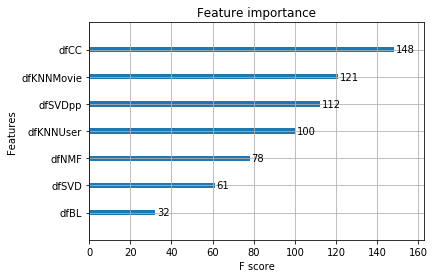

In [309]:
xgb.plot_importance(model)
ids, preds = u.predict_on_models_xgb([algoCC, algoBL,algoSVD, algoSDVpp,algoNMF,algoKNNMovie,algoKNNUser],model)

In [310]:
list_prds=[]
for i in preds:
    list_prds.append(int(round(i[0])))
    
u.create_csv_submission(ids, list_prds, "submissionBlended10.csv")

## our own Blending case

In [ ]:
from sklearn.linear_model import LogisticRegression

df_val=pd.concat([dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO],axis=1)


# model = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
model = LogisticRegression(multi_class='ovr')
model.fit(df_val,y_val)
print("Check classes:",model.classes_)
print(model.coef_)



In [180]:
ids, preds = u.predict_on_models([algoCC, algoBL,algoSVD, algoSDVpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],model.coef_)
u.create_csv_submission(ids, preds, "submissionBlended6.csv")

In [192]:
ids, preds = u.predict_on_models2([algoCC, algoBL,algoSVD, algoSDVpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],model.coef_)
u.create_csv_submission(ids, preds, "submissionBlended7.csv")

[0.5577111989086628, 0.6361808305736592, 0.028724691193409792, 0.0001274179469092424, 0.9999999890658101]
[0.5577113044902643, 0.6361810188767201, 0.028725059168598403, 0.00012741885073906306, 0.9999999890658097]
[0.5577104883357893, 0.6361801392532643, 0.028723906279035247, 0.0001274172854890351, 0.9999999890658117]
[0.5577147760605785, 0.6361843974421949, 0.02872900922362419, 0.00012742277401088135, 0.9999999890658012]
[0.5577107951576223, 0.6361805473098688, 0.02872455481653118, 0.00012741856526750733, 0.9999999890658108]
[0.5577211117298848, 0.6361902804113512, 0.028735719427355085, 0.0001274293837341459, 0.9999999890657842]
[0.5577111453526986, 0.6361808534029761, 0.028724848389145675, 0.00012741859102166885, 0.9999999890658101]
[0.5577096144834953, 0.6361792354140849, 0.028722779367510567, 0.0001274159878633145, 0.9999999890658137]
[0.5577103847487139, 0.636179998281844, 0.028723663228837765, 0.00012741677199935923, 0.999999989065812]
[0.5577115547209031, 0.6361812074589093, 0.02

[0.5508476705949783, 0.642775089227936, 0.01934474864287256, 5.052254438607986e-05, 0.9999999979604827]
[0.5546165180337866, 0.6381446528619068, 0.024857306070553867, 9.150004489806986e-05, 0.9999999940249936]
[0.5525816865557912, 0.6488964885853153, 0.016155428568104563, 3.100269237437018e-05, 0.9999999991382897]
[0.5519436360456628, 0.6529590830321346, 0.013795892438939156, 2.0963807913109798e-05, 0.9999999995724774]
[0.5639149581134334, 0.6343717032525408, 0.036331869063510124, 0.00021708747454523433, 0.9999999709662605]
[0.5623064527870915, 0.6332753142728171, 0.03596958079455018, 0.00021575984053005557, 0.9999999714832187]
[0.5591404696430009, 0.632648685142973, 0.03386543351864078, 0.00019248727830621344, 0.9999999770536785]
[0.5613315802457122, 0.6187462197301244, 0.05844956972784455, 0.0007912999898478513, 0.9999997126282141]
[0.5579647877448543, 0.6340887441652671, 0.03126072873663947, 0.00015864164470459182, 0.9999999838412567]
[0.5583812614892019, 0.6345413982699174, 0.03101

[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.6361732575250367, 0.028714705293094563, 0.00012740469097972379, 0.9999999890658252]
[0.5577042914499676, 0.63617325752503

[0.5524942975936011, 0.6471892998276444, 0.017111958495228022, 3.596206197199533e-05, 0.9999999988772905]
[0.561276439290996, 0.6215889804547399, 0.052393562754959926, 0.0005908515347094792, 0.9999998291501229]
[0.5625764606396495, 0.6188006378327956, 0.060054128794015435, 0.0008378894902239572, 0.9999996797383872]
[0.5683409888377884, 0.612477772714628, 0.08934792042855352, 0.0023026068058809683, 0.9999980082981798]
[0.5627150619576021, 0.6243893085498691, 0.049679341115932904, 0.0005020448968404453, 0.9999998715077645]
[0.5594464568088201, 0.6210890668147129, 0.05087178384091521, 0.0005602326575911268, 0.9999998458069937]
[0.5613883306527391, 0.6203244008243208, 0.05512771837324854, 0.000675278330696302, 0.9999997832157632]
[0.5679370308791697, 0.6245051668735575, 0.058240533795956666, 0.0007186183310363229, 0.9999997510078387]
[0.5628706081503856, 0.6310054860007519, 0.03955868176415712, 0.0002744476882854744, 0.9999999561480817]
[0.5506323235574315, 0.6363957972448389, 0.0240295855

[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.63617505169566

[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.6361750516956637, 0.028717195948501747, 0.00012740835382617986, 0.9999999890658221]
[0.5577058303926958, 0.63617505169566

[0.5637777272488238, 0.6224299778606054, 0.054376824817550705, 0.0006320651231912911, 0.9999998052940863]
[0.5661280424193035, 0.6072286213625258, 0.09826327031474973, 0.003088387494827801, 0.9999966671466981]
[0.5606442830493676, 0.6102376756892571, 0.07540016515442062, 0.0015920093668914867, 0.9999990022970479]
[0.5628213152638003, 0.6140030408873905, 0.07059975271317652, 0.001295968565115659, 0.9999993019580117]
[0.5709463437640123, 0.6059236480202314, 0.11998865936872354, 0.005129936596801343, 0.999991566383364]
[0.5619964479250925, 0.6183719234197674, 0.059613453348705686, 0.0008253191878534898, 0.9999996892980131]
[0.5597304119073754, 0.6169828634069034, 0.058334242415207134, 0.0008031906928446768, 0.9999997067437214]
[0.5688034175383591, 0.6052906048464869, 0.11414293434195773, 0.004568235161585327, 0.9999932072727651]
[0.5588483009656623, 0.6185473101346665, 0.05418829752300899, 0.0006677158336075606, 0.9999997896644688]
[0.5577958066768424, 0.6188338174868244, 0.05205155759067

[0.5621077353915882, 0.6164474334676623, 0.06383349462701804, 0.0009932554936713748, 0.999999567273213]
[0.5744965425375563, 0.6054344385118469, 0.13774312269702008, 0.007339172171023951, 0.9999837213564966]
[0.5617742940513236, 0.6077406227400166, 0.08472776825171499, 0.0021614215780362397, 0.9999982699777477]
[0.5541220190236409, 0.6256245047563141, 0.03768063344270354, 0.00027181976802302476, 0.9999999584574959]
[0.5575428616573264, 0.6175712407976752, 0.054021818564521366, 0.0006739864995130268, 0.9999997872956476]
[0.5542268611556049, 0.6317700333670125, 0.03051636039742042, 0.00015619552600607732, 0.9999999845126899]
[0.5505695698996471, 0.6309422366116667, 0.02886686185670143, 0.00014259269341103877, 0.9999999870356762]
[0.5547860950636887, 0.6352830170060949, 0.02732006366938753, 0.00011647239955268456, 0.9999999907888936]
[0.5548575594402317, 0.6198976436173744, 0.04651878350452663, 0.0004691330294399865, 0.9999998897833894]
[0.5559354068653443, 0.6231442114973583, 0.042780775

[0.5640382815408678, 0.6115526835476177, 0.07927543255855546, 0.0017499535998923795, 0.9999988018092011]
[0.556688119533744, 0.6227501563859366, 0.04432152002655333, 0.00040292042318530453, 0.9999999152708605]
[0.5596635435787856, 0.6131425998624537, 0.06632233004764357, 0.0011384790015500222, 0.999999453467395]
[0.568198703626508, 0.6055473210601232, 0.11034517894579031, 0.004188205806679204, 0.9999941980663988]
[0.5575496276859061, 0.6224165435219204, 0.04575938680739878, 0.00043316587712432223, 0.9999999032737409]
[0.5521460446731068, 0.6292894485534558, 0.031696373697776094, 0.000177999002941897, 0.9999999806147835]
[0.5787077710086905, 0.620875369840606, 0.09674271839267998, 0.00254247503814254, 0.9999975129111435]
[0.5569609113763457, 0.6231221637551778, 0.044017811561688165, 0.00039355175394948787, 0.9999999187040458]
[0.5618068032768443, 0.6145897694167635, 0.0668881962137714, 0.0011333164536611643, 0.9999994530814125]
[0.5605383339296545, 0.6077308365554288, 0.0815054880349378

[0.5657631143068372, 0.6126259452057938, 0.0804467998673991, 0.001787279701960678, 0.9999987457749393]
[0.5578752581551307, 0.6195399397830925, 0.051002044069014846, 0.0005756285237063559, 0.9999998391899388]
[0.5675237920671123, 0.6071522965823697, 0.1029123322518087, 0.0034614947436602773, 0.9999958868988882]
[0.5594151798720085, 0.6084486253030558, 0.0772879768575459, 0.0017305960832688734, 0.9999988480878648]
[0.5609503865838704, 0.6139572224060006, 0.06701767173822042, 0.0011499414707149057, 0.9999994408896462]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548005

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.0287234795480055, 0.00012741671399642447, 0.9999999890658124]
[0.5577101854250218, 0.6361798158807074, 0.028723479548

[0.5521721697037346, 0.6238188445301308, 0.038450058625469845, 0.0002944219527066393, 0.9999999525560532]
[0.5504522197875369, 0.6384933901053981, 0.022151318459356677, 7.195325373854657e-05, 0.9999999961686356]
[0.5688928804167179, 0.6111884780962564, 0.09648329735225739, 0.0028349406411946254, 0.9999971063547489]
[0.5571606839442804, 0.6172298643063008, 0.0543407200607953, 0.0006877853689837502, 0.9999997799148503]
[0.562166703224073, 0.6130658669665043, 0.0722582727309698, 0.0013877135103582707, 0.9999992145790207]
[0.5764849190964756, 0.6128841981709844, 0.11558772374160835, 0.004332613063442492, 0.9999936098812969]
[0.5531756848528501, 0.6102243005187374, 0.06229966416621344, 0.0010482095121568382, 0.9999995417370665]
[0.5562009868334973, 0.6158542549910722, 0.05585121199594539, 0.0007520813166820635, 0.9999997430447997]
[0.5600335345003266, 0.6158323486111245, 0.06203167661046441, 0.0009433682876453494, 0.9999996090447753]
[0.5507082969667091, 0.6302819322646666, 0.02975259198485

[0.5559222029297025, 0.6120736459768586, 0.06277454895563761, 0.001029388924460644, 0.9999995509991356]
[0.557434637086569, 0.6140717549694644, 0.06134541778373609, 0.0009496555850438847, 0.9999996087749441]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422

[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.028722527104

[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.028722527104

[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.02872252710422617, 0.0001274159070087712, 0.9999999890658142]
[0.5577093443847736, 0.6361789773861181, 0.028722527104

[0.5672265355185712, 0.6224030896688126, 0.0617652577490447, 0.0008511786683548495, 0.9999996641314162]
[0.5504312447577091, 0.652300786052766, 0.013655184974681708, 2.082225118194176e-05, 0.9999999995800074]
[0.5767189351752326, 0.619482121442385, 0.09629483224737988, 0.0025622475217560504, 0.9999974978052828]
[0.5649246333294198, 0.6294408226365071, 0.04469602699117726, 0.0003692062487156934, 0.999999924943298]
[0.5705494591432474, 0.6196412993754399, 0.07627285649638162, 0.0014469862598903774, 0.9999991223794591]
[0.5627126429320363, 0.6336855513282031, 0.03613768330498555, 0.0002167176794107431, 0.9999999712410187]
[0.5637343681045205, 0.625269655202109, 0.050089223706869086, 0.0005079771680662899, 0.9999998681588503]
[0.5617756747549849, 0.6283188938754862, 0.042320722114479674, 0.00033319618544027085, 0.9999999383185985]
[0.5583360767861515, 0.6314922505793407, 0.034482958532326344, 0.00020387612538665643, 0.999999974668372]
[0.561393905046733, 0.6306410725586963, 0.0387051973890

[0.55827991543496, 0.6331525058358874, 0.032464403754865374, 0.00017424791035477313, 0.9999999808520591]
[0.5614243723162102, 0.6256944142106345, 0.04611582947101528, 0.00042060792238287026, 0.9999999067545657]
[0.5588934618750763, 0.6387315683052203, 0.027057603097211017, 0.0001073911053696199, 0.9999999918942336]
[0.5631804354690932, 0.6305010658162009, 0.04097068334667289, 0.00030067632256802784, 0.9999999483196161]
[0.5664618557618748, 0.6264165580513473, 0.052236689016737274, 0.0005489178435910485, 0.9999998467720873]
[0.5565759141637201, 0.6365709208380873, 0.027549904216204023, 0.00011634230864514043, 0.9999999907462281]
[0.5610324126257241, 0.6308267847586881, 0.037905387392815106, 0.00025141425626675493, 0.9999999627797722]
[0.5545166751703461, 0.6463386682693891, 0.018536634298288515, 4.301550037875605e-05, 0.9999999984430168]
[0.5584511666800045, 0.6359467217061192, 0.029558713347787858, 0.00013596394628592222, 0.9999999876861665]
[0.5617564609097713, 0.6358944517615395, 0.0

[0.5555611245949753, 0.6396739746577745, 0.023974955175822796, 8.217171714834698e-05, 0.999999995037301]
[0.5696169802260874, 0.622798443904419, 0.06585302631583348, 0.000983157709904734, 0.9999995610583559]
[0.5662524530291032, 0.621456423655514, 0.06168688999157133, 0.0008595276543046603, 0.999999659533879]
[0.5844303145217462, 0.6470080337702293, 0.04821133146707598, 0.0003572174920800276, 0.9999999228300925]
[0.5592926359548822, 0.6348514803383204, 0.03142058163388773, 0.000157670979131641, 0.9999999839098184]
[0.5592643518569518, 0.6320072388177194, 0.034678207465858, 0.0002041821579027983, 0.9999999744970813]
[0.5610971778910888, 0.6305578984577267, 0.0383906813686624, 0.00026000501706970454, 0.9999999604676584]
[0.5559788122077902, 0.6354744191480728, 0.02819914651278671, 0.0001245729410884307, 0.9999999895758507]
[0.5609516857490685, 0.6248627010563164, 0.04677527328565806, 0.000439385692452819, 0.9999998993931224]
[0.5595916377405088, 0.6294320480109881, 0.038292577750063346, 

[0.5543694423179648, 0.6380112758512639, 0.024806453457996404, 9.136953109775204e-05, 0.9999999940439394]
[0.5507566025906161, 0.6567925496510163, 0.011705940752075556, 1.4003399257398094e-05, 0.9999999997925785]
[0.5660202460943854, 0.6234481145978495, 0.05733679916526875, 0.0007087460878522356, 0.999999758818211]
[0.5503415545837, 0.6462476489650615, 0.016915842724055802, 3.615488620569691e-05, 0.9999999988782423]
[0.5507735926132994, 0.645228821576015, 0.017702622077076766, 4.032817486130955e-05, 0.9999999986348138]
[0.5569488895674121, 0.6354342832911813, 0.028936432030972868, 0.00013132974290626303, 0.9999999884995986]
[0.553594072847973, 0.6485046642809078, 0.016775853063860514, 3.373114598724586e-05, 0.9999999989938088]
[0.5605737856521427, 0.63139541338072, 0.03669245849773196, 0.00023232653126066722, 0.9999999677225335]
[0.5504371804413835, 0.643122680561043, 0.0189380297297658, 4.823685100183174e-05, 0.9999999981251602]
[0.5526691047539871, 0.6477016805482092, 0.0169011397687

[0.5600099026673114, 0.6366129202010165, 0.030068985020125154, 0.00013918268717695071, 0.9999999870731546]
[0.5590700615478947, 0.6343798418007168, 0.03176645063161034, 0.00016262258020378523, 0.9999999830180987]
[0.5615149413891226, 0.6271703060318428, 0.04375938091075974, 0.00036540046093545955, 0.9999999273722433]
[0.5625899998791921, 0.6305618404393304, 0.04008835292142197, 0.00028613728145783247, 0.999999952787098]
[0.5656227586401527, 0.6271431524250305, 0.04961747410512571, 0.0004828189785973912, 0.9999998785955948]
[0.5642061746158492, 0.6237657940329736, 0.05349561856203828, 0.0006020080420728721, 0.9999998211506136]
[0.5648880618869071, 0.6323957236771242, 0.04030182528650954, 0.000281674885520476, 0.9999999536391793]
[0.5661365432309283, 0.6308028191284698, 0.04419808809490381, 0.000353096768879442, 0.9999999303107087]
[0.5645136646286587, 0.6192985723389844, 0.06318904306484532, 0.0009382871049839725, 0.9999996050706411]
[0.5619787164916198, 0.6243015244598173, 0.0491420998

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.028716310359415704, 0.00012740741852118145, 0.9999999890658233]
[0.5577051869198438, 0.636174345111838, 0.0287

[0.5634678506765364, 0.648502872233732, 0.021785902171957472, 5.781750211223805e-05, 0.9999999972600179]
[0.5703074186180159, 0.6378875125187468, 0.03987181035739603, 0.00025634443470493886, 0.9999999598897875]
[0.5704269284757613, 0.6362274985002749, 0.04256423013017547, 0.00030357250593479216, 0.9999999457914625]
[0.569217493313625, 0.6325432987007796, 0.04653208791706065, 0.0003904078323479156, 0.9999999155700021]
[0.5597126657323256, 0.6384483488705285, 0.028124220268064597, 0.00011792417656920273, 0.9999999904048156]
[0.5611041991301079, 0.648132424761962, 0.020594603096780018, 5.152247953295507e-05, 0.9999999977899802]
[0.5607127286286503, 0.6455211493637367, 0.0224159516895734, 6.457037132422003e-05, 0.9999999967023354]
[0.5561165094177948, 0.6585453303787256, 0.012403813587501726, 1.5029949653854446e-05, 0.999999999759265]
[0.5683177608611857, 0.6406697521866408, 0.033670593749037206, 0.00016849637628378724, 0.9999999811725013]
[0.5621151319858215, 0.6603247230907999, 0.0135576

[0.5586443197826393, 0.6476453654610455, 0.01964228326390285, 4.724062281541551e-05, 0.9999999981276635]
[0.5579321933496444, 0.6580268901550647, 0.01321392947329456, 1.7214648012599267e-05, 0.9999999996909175]
[0.5583154732170773, 0.6517003123081074, 0.016812162719912198, 3.1785957622872284e-05, 0.9999999990769741]
[0.5602125480293133, 0.6492804898570619, 0.01929962899638051, 4.415287446267829e-05, 0.9999999983283844]
[0.5545255084707729, 0.6555235582221792, 0.013333795446370218, 1.8507633994106015e-05, 0.9999999996536284]
[0.568002482371664, 0.6353693344833209, 0.040354553327775794, 0.0002721051771034849, 0.9999999558477166]
[0.5549510460302575, 0.6469439269436177, 0.0183488943725026, 4.1751855776629106e-05, 0.9999999985215985]
[0.5574191202623437, 0.6546542202803954, 0.014762253308963736, 2.3057166658708626e-05, 0.9999999994811357]
[0.5624787227166744, 0.6444066400554681, 0.024566277904544187, 7.994277861408925e-05, 0.9999999951417453]
[0.5641792915620107, 0.6459978492065785, 0.0243

[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.63617042363874

[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.63617042363874

[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.63617042363874

[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.63617042363874

[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.63617042363874

[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.63617042363874

[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.6361704236387425, 0.028710553030583674, 0.00012739783913563266, 0.9999999890658295]
[0.5577020062185649, 0.63617042363874

[0.5554294717064663, 0.6426077864200516, 0.02164605332018819, 6.33604656626676e-05, 0.9999999968828541]
[0.5565780297643602, 0.6449227072843182, 0.020477358822344593, 5.395745724301314e-05, 0.9999999976456884]
[0.5687951432491284, 0.6239187162979379, 0.06200175377599201, 0.0008447910423516785, 0.9999996663157764]
[0.5665006753809458, 0.6227526151925582, 0.06003546613287806, 0.0007960677786237479, 0.999999703077973]
[0.5617751051611751, 0.6304800073865146, 0.039472842338313475, 0.0002776805622710539, 0.9999999554560799]
[0.5581292653496674, 0.6410563222903879, 0.024510901944130394, 8.411579110666809e-05, 0.9999999947757151]
[0.5563921961896554, 0.639829612853998, 0.024459996585143567, 8.563596926785973e-05, 0.9999999946465901]
[0.5488032265526654, 0.6463684612782852, 0.016315429221152544, 3.373077979535184e-05, 0.999999999016226]
[0.5584449953943371, 0.6439134990946566, 0.022199861735612624, 6.47081569252334e-05, 0.9999999967179865]
[0.5559301222169949, 0.6370711509821727, 0.02667550519

[0.5609752159093219, 0.6335772657578188, 0.034519603390842646, 0.0001973110757187282, 0.9999999758403388]
[0.5594397448598252, 0.6262004157557659, 0.04296488921589825, 0.0003582959256907589, 0.9999999306072289]
[0.5582377038861078, 0.6345273084953235, 0.03097897839917107, 0.00015436596081748656, 0.9999999845846551]
[0.5713393927904776, 0.6218570897273401, 0.07219716314636544, 0.001236699013756905, 0.9999993340442411]
[0.5672871909668278, 0.6288162258681245, 0.04963615566808462, 0.00047383546331604285, 0.9999998817584309]
[0.5646679553293459, 0.6171124635815061, 0.06876200548336364, 0.0011805773645566424, 0.9999994048904614]
[0.5579641048244985, 0.6321528413522106, 0.033426982807630595, 0.00018892230022406152, 0.9999999779335753]
[0.5535882250907478, 0.647652188432786, 0.017303189653930528, 3.6562005552024586e-05, 0.9999999988388285]
[0.5589528913138141, 0.6344815039189028, 0.03162273933372953, 0.000161227976699563, 0.9999999832903528]
[0.5621133954978517, 0.6301742116331223, 0.04031912

[0.5533891939087576, 0.6491847715396625, 0.016303215445458662, 3.143806997042239e-05, 0.9999999991135091]
[0.5615590833445241, 0.652030996314632, 0.018052237942794, 3.6415475980937495e-05, 0.9999999988060121]
[0.556530447809044, 0.6388033562011507, 0.025461624950733598, 9.472981556214319e-05, 0.9999999935903817]
[0.5574742848416174, 0.6349103776720741, 0.02996284530723176, 0.00014306802749853418, 0.9999999865820033]
[0.5568821220830728, 0.6413550130473528, 0.023484859350033034, 7.660781722513376e-05, 0.9999999956018271]
[0.5586390406881022, 0.6379025529931233, 0.027799909378957096, 0.00011554974279901673, 0.9999999907901194]
[0.5552921070314865, 0.6441508908486052, 0.02041932016209139, 5.4535110158410983e-05, 0.9999999976158384]
[0.554413199180583, 0.6444117377397823, 0.01979826945950906, 5.099988549800061e-05, 0.9999999978916271]
[0.5573868831146377, 0.6362022892497136, 0.02857133825353446, 0.00012663146969787525, 0.9999999892083226]
[0.5586749809417585, 0.6361791694414856, 0.02957417

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.6361738239736634, 0.028715568846478298, 0.00012740627020310137, 0.9999999890658242]
[0.5577047465375189, 0.63617382397366

[0.5590106502090143, 0.6453562637482128, 0.021385438046287442, 5.829808499687796e-05, 0.9999999972676656]
[0.5526962714715768, 0.6537537818846163, 0.01359079562139181, 1.9906469727265716e-05, 0.9999999996079401]
[0.5521411146041876, 0.6517193401172521, 0.014459092328980589, 2.3502364217919567e-05, 0.9999999994747479]
[0.5691052837044324, 0.6318767422588669, 0.04701114283799271, 0.0004006131783788657, 0.9999999116237563]
[0.5505750740655935, 0.6408915123967915, 0.02054427845886753, 5.929794077985561e-05, 0.9999999972895657]
[0.5904682157037957, 0.6473487646382978, 0.0644058884761044, 0.0007271950242586033, 0.9999997173007799]
[0.5595819105730448, 0.6413200089335345, 0.025064762984500197, 8.725488659117717e-05, 0.9999999943806908]
[0.5550059675776604, 0.647955243642193, 0.017638804700982884, 3.753658016362824e-05, 0.9999999987741471]
[0.5494034970986034, 0.6438941011667058, 0.01793199123218249, 4.242659972146416e-05, 0.9999999985120595]
[0.5600999639465247, 0.6308617493755462, 0.03688801

[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.028710484877508113, 0.0001273971652791411, 0.9999999890658295]
[0.557702060731277, 0.6361704547663316, 0.0287104848775

[0.5566249597090293, 0.6425053393376657, 0.022364113755186387, 6.76833915409362e-05, 0.9999999964751456]
[0.5499450871703051, 0.6599716707386368, 0.010262771022092573, 1.0133811481907245e-05, 0.9999999998838563]
[0.5718947407638469, 0.6226834070502584, 0.07185185928696788, 0.00121239994589767, 0.9999993556305584]
[0.5516253379154458, 0.6553876425994001, 0.012541042741929633, 1.6473534054516772e-05, 0.9999999997218448]
[0.5587552396164743, 0.6284158865077257, 0.03884159811323057, 0.00027685878571766465, 0.9999999562365024]
[0.5718113493460916, 0.6228651446778358, 0.07102888067199875, 0.001176084780906693, 0.9999993899079066]
[0.5700266374893185, 0.6228916196896346, 0.06684573504858883, 0.0010201176549422734, 0.9999995302105448]
[0.5624071177308175, 0.6326621434845843, 0.03717509215759713, 0.000235177161853237, 0.9999999667633268]
[0.5619753074968649, 0.6312230038809714, 0.038453559115751774, 0.00025827946509107154, 0.9999999607767471]
[0.5711635855312563, 0.6248526684084214, 0.064847532

[0.5575471364099492, 0.6405341209781075, 0.024513386957742044, 8.468246524068147e-05, 0.9999999947219281]
[0.5602277824339967, 0.6417645803496951, 0.025205575832654706, 8.768701368060315e-05, 0.9999999943199244]
[0.5540182207815877, 0.6473225280832207, 0.017656762589550325, 3.8157757198754904e-05, 0.999999998744278]
[0.5572637447511015, 0.6417165115930641, 0.02332723841097407, 7.473785544641452e-05, 0.9999999957805304]
[0.5533790325950625, 0.6564260180685882, 0.012550830707749079, 1.6078564986780092e-05, 0.9999999997314847]
[0.5542439097631089, 0.6450291122832539, 0.019263542161970806, 4.761354002460575e-05, 0.9999999981349443]
[0.556935516480895, 0.6422806686698685, 0.022660967818852597, 6.967446828971835e-05, 0.9999999962807432]
[0.5578835647177426, 0.6375028812548577, 0.02751925360967151, 0.00011372718461646833, 0.999999991062752]
[0.5589191817136323, 0.6369582030484958, 0.02888724701718718, 0.00012728331255416813, 0.9999999890315588]
[0.5740326030828738, 0.6210023871135557, 0.08240

[0.5521798622932065, 0.6500672625146766, 0.015366635037109281, 2.746215867741604e-05, 0.9999999993070582]
[0.5561291157398076, 0.6456348005579398, 0.019694785899842568, 4.906332268005969e-05, 0.999999998015392]
[0.5623692836865541, 0.6353972308229117, 0.033609996113664706, 0.000180357132373283, 0.9999999792842857]
[0.5625470026588716, 0.6305215707200827, 0.0400840060989556, 0.00028621348597322337, 0.9999999527736344]
[0.5573235410177549, 0.6388184492902506, 0.02593532516717225, 9.827051546814878e-05, 0.9999999931299846]
[0.5608419687295669, 0.6375139160985187, 0.029716178756960344, 0.0001333744352720821, 0.9999999879749748]
[0.559036632582539, 0.637823811010551, 0.02811381254358261, 0.00011840612171206289, 0.9999999903528292]
[0.5572210788456328, 0.6447970525427029, 0.02087723634311479, 5.612696740560858e-05, 0.9999999974671683]
[0.5560440098935352, 0.6501157251171865, 0.016793569715510503, 3.2660520563455754e-05, 0.9999999990402079]
[0.5564835750183197, 0.6453805778835882, 0.020032278

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.028714427168173365, 0.00012740443298607098, 0.9999999890658255]
[0.55770409075885, 0.6361730335656739, 0.02871442716817

[0.5515912905355993, 0.6512370677596981, 0.014517172799710792, 2.3916293350134124e-05, 0.9999999994592381]
[0.5621705788013918, 0.6271534130301277, 0.04443618022892363, 0.00037708617891971417, 0.9999999229556547]
[0.5585231073666893, 0.6305417390437884, 0.035781779886442884, 0.0002233036455908982, 0.9999999702032868]
[0.5602586695974335, 0.645599673700756, 0.02186972297074035, 6.069856187292092e-05, 0.9999999970483737]
[0.5598812322619707, 0.6456373157819612, 0.021638647300519284, 5.935679580801232e-05, 0.9999999971682222]
[0.5597204156497827, 0.6335751493822788, 0.033141102112473925, 0.00017988580523027294, 0.9999999796138244]
[0.5539348539168151, 0.6407632035103468, 0.022226412861266413, 6.909002726165876e-05, 0.9999999963846384]
[0.5770943478269295, 0.6119032275140482, 0.12491110949615568, 0.0053537189410745095, 0.9999906344841117]
[0.5580794367940869, 0.6367129023996969, 0.028351891841345747, 0.0001225306139629584, 0.999999989780229]
[0.5689895637312675, 0.6165820124206866, 0.07978

[0.5595758171243481, 0.6311186540529291, 0.03600786228107168, 0.00022401161359303224, 0.9999999698840514]
[0.5616390942347822, 0.6322343263594724, 0.03667921266430099, 0.00022895030793418836, 0.9999999684041915]
[0.5785050825527545, 0.6097271894650695, 0.14119015266211457, 0.007522553509787056, 0.9999826589426183]
[0.5548396748439731, 0.6340499517282587, 0.028732658470397854, 0.00013269443037240757, 0.9999999883868257]
[0.5600341396628341, 0.6303702656573796, 0.037468774993428745, 0.00024701158337504304, 0.9999999640937499]
[0.5560183584803943, 0.6368436178417828, 0.026847346052421072, 0.00010940333423086772, 0.9999999917256616]
[0.5548703559803524, 0.642989748214308, 0.02099895034168736, 5.886738487601986e-05, 0.9999999972707498]
[0.5543713925200329, 0.6431841493993277, 0.020607284925334323, 5.6447948396855654e-05, 0.9999999974732361]
[0.563414740397924, 0.6265400381250853, 0.04677733304397452, 0.00042562564834535495, 0.9999999038638361]
[0.5609873422698568, 0.6280659462875454, 0.0415

[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404

[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404

[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404437688, 0.0001274088158787833, 0.999999989065822]
[0.5577058578940257, 0.6361751103128399, 0.028717342404

[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0001274153685664157, 0.9999999890658149]
[0.557709055625335, 0.636178673000823, 0.028722114298917405, 0.0

[0.5598985666781849, 0.638379448118788, 0.028195365432337395, 0.00011802940279848465, 0.9999999903663899]
[0.5580936098206555, 0.6393700094602113, 0.0259845298068175, 9.793572295726299e-05, 0.9999999931487196]
[0.5626529495009933, 0.626264415495257, 0.04689699319616465, 0.00043300214232356215, 0.9999999012817303]
[0.5645776099291672, 0.6290823580690709, 0.045144713527673096, 0.0003814088945397441, 0.9999999206360941]
[0.5544273925663488, 0.6477833788668903, 0.017551587910310293, 3.738422253380726e-05, 0.999999998787507]
[0.562373182963884, 0.6334936916815925, 0.036026924016750915, 0.00021626733337687886, 0.999999971386249]
[0.5677643208490434, 0.630387064519513, 0.04766042008402694, 0.00042290252388231883, 0.999999903235865]
[0.5609936998712592, 0.6336107990390374, 0.03454867569253734, 0.00019775031510325177, 0.9999999757465363]
[0.5607967296415184, 0.6350589603884316, 0.032562238776233585, 0.00016966288161134692, 0.9999999815500062]
[0.5637289583268029, 0.627733244351916, 0.0459900711

[0.5690330769472542, 0.6210219404080969, 0.06798886233645633, 0.0010801268055808944, 0.9999994822860683]
[0.5679445288440028, 0.6273136611777235, 0.05251386923512205, 0.000546568387754394, 0.9999998469816955]
[0.5758178907054947, 0.6140637266952709, 0.11061987529381492, 0.0038336665222612394, 0.9999948809023385]
[0.5651989544488786, 0.6243091507921016, 0.053061241265658324, 0.0005818880412638013, 0.999999830972248]
[0.5722586662474842, 0.6157846792688183, 0.0907936778280922, 0.002300754104673649, 0.9999979761255918]
[0.5654409886426882, 0.6215970792033632, 0.0588459459927817, 0.000765823994725448, 0.99999972384207]
[0.5602595408217452, 0.6299205252666473, 0.03801941238041337, 0.0002562306635841863, 0.9999999616026174]
[0.5586610266859707, 0.6231546967791058, 0.04628108860696413, 0.0004397194067342836, 0.9999999002129435]
[0.5559453273079346, 0.6389658513580583, 0.02479615299641657, 8.912186932353594e-05, 0.9999999942565189]
[0.5686525558703065, 0.6312338816270526, 0.045757019927078355,

[0.5631973332192635, 0.621221812917305, 0.0560935343693097, 0.0006923706576967333, 0.9999997714298076]
[0.5667641785410678, 0.6199567178961777, 0.06450360279988211, 0.0009661219073611485, 0.9999995798125328]
[0.5608629126930125, 0.6309366655861398, 0.037469653177540654, 0.00024436114270706075, 0.9999999646411314]
[0.5704184074142322, 0.6168212449801688, 0.08230628778320455, 0.0017896178657089044, 0.9999987185511199]
[0.5605616120527046, 0.6207104564423326, 0.05288742528696875, 0.0006121604993716903, 0.9999998184805058]
[0.5576544694027793, 0.6361390629050783, 0.0287039094502602, 0.00012702481853118329, 0.9999999891321679]
[0.5707205833848992, 0.6187318667947418, 0.07744890264194487, 0.0015076692330410377, 0.9999990556719403]
[0.5795158903909942, 0.6131601520978593, 0.13077814294639598, 0.005935127192173407, 0.9999886234207207]
[0.5555797676286739, 0.6452879521704185, 0.019552075013173176, 4.848774179283199e-05, 0.9999999980601194]
[0.5561338930066495, 0.6386797451902118, 0.025058684021

[0.5645440645432986, 0.62584311549757, 0.04931934699434165, 0.0004826172211116259, 0.9999998792321114]
[0.5557348526538225, 0.6385194455923857, 0.025107252724426345, 9.229535080439902e-05, 0.9999999938949637]
[0.5627576248703495, 0.6282877628313612, 0.043484890774096265, 0.00035330229383240367, 0.9999999312307675]
[0.5582008669370936, 0.6360751379822874, 0.02893114566276071, 0.00012887699246754303, 0.9999999888120225]
[0.5601669304251006, 0.6313789676537338, 0.035950208714655936, 0.00022166981519694502, 0.9999999703452955]
[0.5664417366643024, 0.6227479587599934, 0.05913847468417805, 0.0007645688992272859, 0.9999997235405216]
[0.5571701723049327, 0.6371565630505669, 0.027274193421335458, 0.00011218502324830297, 0.9999999913012044]
[0.572497152739609, 0.614324307802763, 0.09687988943165662, 0.002748818645523189, 0.999997214721298]
[0.5592964203655584, 0.6361952371403877, 0.0296712644382645, 0.00013580917134920091, 0.9999999876534271]
[0.5675620737050006, 0.6129644660428403, 0.0851859775

[0.5731054354542224, 0.6084032731477607, 0.12043178219715318, 0.005047589125998185, 0.9999917268356728]
[0.5618506790740168, 0.6276321212853645, 0.04282074256449457, 0.0003439507395823215, 0.9999999346541464]
[0.5577505631312162, 0.638270889497625, 0.026452684294472954, 0.0001027703046438154, 0.9999999925387262]
[0.5581769308891034, 0.6318696852329184, 0.033553655051196285, 0.00018995958476341314, 0.9999999776658983]
[0.555621038440759, 0.6417489635492947, 0.02222769658142771, 6.742738704388356e-05, 0.9999999965100754]
[0.5603039750822766, 0.6311391939226104, 0.03641181722250487, 0.00022854007158757975, 0.999999968681133]
[0.5536562826761923, 0.6469896127498679, 0.017675385283325042, 3.8453042158153676e-05, 0.9999999987277177]
[0.5579797863045598, 0.6366520519240597, 0.028213488845933308, 0.00012119419452485082, 0.9999999899778999]
[0.5733497565483716, 0.6093939297986882, 0.1179565922332254, 0.004725880301808492, 0.9999926468452055]
[0.5716951992442264, 0.6117107482668336, 0.1030763967

[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.

[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.

[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.

[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.

[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.

[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.

[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.0001274128339659615, 0.999999989065818]
[0.5577077266154136, 0.6361772198627558, 0.02872020127514447, 0.

[0.5646330225211901, 0.6203276133910808, 0.061084764220645286, 0.0008550840280584454, 0.9999996650275276]
[0.5608740287613416, 0.6223319104076486, 0.05089618097228043, 0.000549696825887755, 0.9999998501403303]
[0.5573910709326102, 0.6339247673958862, 0.030860000661829763, 0.000154453037702853, 0.9999999846149027]
[0.5558014092765704, 0.6385736906341637, 0.025145398892461875, 9.254580143500426e-05, 0.9999999938672008]
[0.5726866955736588, 0.608389083629597, 0.12026611159639687, 0.005060173802932071, 0.9999916987372095]
[0.5587186497003553, 0.6358052785049241, 0.029871050512437658, 0.0001392224706506935, 0.9999999871389806]
[0.5641379907910703, 0.6223114651849652, 0.05595634395609542, 0.0006801499176204156, 0.9999997776480982]
[0.5586830544821844, 0.6248348682191194, 0.043793331661433926, 0.0003801510072053519, 0.9999999229929585]
[0.5624443438493656, 0.6219944019221291, 0.05386642199194412, 0.000627777885971483, 0.9999998086812362]
[0.560292326629919, 0.626000593905464, 0.04404660901136

[0.5584087362825425, 0.6220359748565989, 0.0479545399804502, 0.0004853260838369497, 0.9999998811869472]
[0.5590597807023656, 0.6256725816016568, 0.04310384394531909, 0.000362625430765823, 0.9999999291373796]
[0.5653469255916642, 0.6413664683546413, 0.029618235769532517, 0.0001246321294836656, 0.9999999891378627]
[0.5563711186890354, 0.629744687055938, 0.03479125556838452, 0.00021429034794455697, 0.9999999725509721]
[0.5549665178589843, 0.6108344082570064, 0.06395486586862946, 0.0010968685876065276, 0.9999994994519369]
[0.5581887758598166, 0.6327674704861566, 0.03279855418498368, 0.0001788225044101524, 0.9999999799628314]
[0.564277375101845, 0.6227824330420761, 0.055515171986614265, 0.0006649059352061905, 0.9999997863694434]
[0.5635012983897814, 0.6172423480687049, 0.06539520935620999, 0.0010423776962515763, 0.9999995254175839]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787

[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028

[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028

[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028717592787341224, 0.0001274091102315164, 0.9999999890658217]
[0.5577060344154371, 0.6361753055312956, 0.028

[0.5577063059662726, 0.6433219278004326, 0.02228971393088931, 6.611785643651333e-05, 0.999999996600503]
[0.5583108706868593, 0.6415195147300806, 0.024094605662209858, 8.010485965766872e-05, 0.9999999952026847]
[0.5595736140231432, 0.6372969645211045, 0.028897776811042268, 0.00012618248727450416, 0.9999999891626344]
[0.5599875157573632, 0.6347135017045217, 0.031891057576777175, 0.00016238054620011975, 0.9999999829781181]
[0.5725141517424561, 0.6199227196511934, 0.08020835753087263, 0.001625918026627634, 0.9999989095679543]
[0.5681916560989134, 0.6232833624706254, 0.06147223450185727, 0.00083104994627795, 0.9999996766979274]
[0.5588125486533868, 0.6386785911495293, 0.027030697342899094, 0.00010726782476297822, 0.9999999919112037]
[0.5634261188719579, 0.633977772936161, 0.03598098105892932, 0.0002128767342515353, 0.9999999720265892]
[0.5568449359890392, 0.6382392467648775, 0.026022606469960876, 9.984119009903297e-05, 0.999999992938022]
[0.5636474262936999, 0.6356301786344914, 0.0343748653

[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.6361726607654212, 0.028713872392464652, 0.00012740346652297674, 0.9999999890658262]
[0.5577037902015587, 0.63617266076542

[0.5535264954734208, 0.6272941264982227, 0.035308768371273884, 0.00023185772069152745, 0.9999999688142757]
[0.5800590502362514, 0.6409621939506968, 0.05088832459823427, 0.00043378483693233446, 0.9999998930174768]
[0.5606452949927206, 0.6313740083445258, 0.036920014052157994, 0.00023605449640537986, 0.9999999667981021]
[0.5496812726028284, 0.6270633595373326, 0.03254456196987433, 0.00019768287951697885, 0.9999999769310793]
[0.560619758751408, 0.629345911003892, 0.03959553685934933, 0.00028417681929108617, 0.9999999537735903]
[0.5555716540416349, 0.6435735744808541, 0.02096582527978095, 5.810081803703207e-05, 0.9999999973268285]
[0.5693160380494183, 0.6239202158863253, 0.06275673215945714, 0.0008663200299653599, 0.9999996501852404]
[0.5600342977327705, 0.6353045499964165, 0.03156401799738434, 0.00015814776074299163, 0.9999999837631326]
[0.5674218903056546, 0.6253637698956919, 0.05591149113602074, 0.0006497206669351303, 0.9999997922832632]
[0.5566755801490433, 0.638466980268182, 0.0258115

[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.028

[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.02871518369119984, 0.00012740556844400574, 0.9999999890658247]
[0.5577045428645183, 0.6361735703687393, 0.028

[0.5525729210778559, 0.6483083245643128, 0.01649822973690671, 3.274381068109573e-05, 0.9999999990500538]
[0.5561457308111487, 0.6407368861467672, 0.02350008075392691, 7.741328552521153e-05, 0.9999999955300511]
[0.5571506685219124, 0.637090783040503, 0.027416406069723696, 0.00011384049693259718, 0.9999999910746802]
[0.5614694745751491, 0.6336734999917395, 0.034845230813738894, 0.00020078321778119925, 0.9999999750208372]
[0.558300960457889, 0.6302340306463929, 0.03606284150390044, 0.00022934890517316815, 0.9999999687810073]
[0.56604368861445, 0.629965970496472, 0.0454517863378973, 0.00038109171451400326, 0.9999999201802813]
[0.5641849419841721, 0.6385651468739331, 0.03163982288502893, 0.00015049450279759494, 0.9999999848729492]
[0.5690527557061836, 0.6163178766285234, 0.08103828059521084, 0.0017459831516088136, 0.9999987803105135]
[0.5516185078057009, 0.6523088831759422, 0.014006861742621288, 2.184285503863069e-05, 0.9999999995402734]
[0.5533168276388788, 0.6540142912206514, 0.0136889489

[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.028715473968

[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.02871547396835129, 0.0001274062045169219, 0.9999999890658244]
[0.5577046713307067, 0.6361737424586227, 0.028715473968

[0.5538118010998354, 0.6280847405807625, 0.034530768135151615, 0.00021708253726684544, 0.9999999722322002]
[0.5523075332127949, 0.6373377588406791, 0.024044650456907818, 8.66448099927442e-05, 0.9999999946203425]
[0.5544508628615401, 0.6267281268084159, 0.036786830717580855, 0.00025431987703348444, 0.9999999630773324]
[0.557896577767165, 0.6225023323118594, 0.04615857338470441, 0.00044134693906309276, 0.9999998998249864]
[0.553305847303916, 0.6235956192949007, 0.039769861092376124, 0.0003166252360630924, 0.9999999457116377]
[0.5575945482422708, 0.6225779104322543, 0.045673730289404996, 0.00043059132271735227, 0.9999999042862578]
[0.556582349681435, 0.6217720026389976, 0.045899630139449706, 0.000441953884031787, 0.9999999002123591]
[0.5647093021513229, 0.6156806517866664, 0.07099736449320247, 0.0012824709609910673, 0.9999993096964812]
[0.5597900961134383, 0.6182292608562544, 0.05667219101975725, 0.0007442226978263673, 0.9999997437487328]
[0.5519770693436156, 0.622997246005824, 0.03928216

[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.028725771610

[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.028725771610

[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.5577118033999989, 0.6361815502147522, 0.0287257716107854, 0.00012741982351654628, 0.9999999890658083]
[0.565859892190329, 0.6165602504762099, 0.07102498301087364, 0.0012646112929604496, 0.9999993238373505]
[0.5476359402275639, 0.642143243417113, 0.018454299314589938, 4.696046364632595e-05, 0.9999999982332439]
[0.5645300275750139, 0.6238590208114715, 0.05293960503506616, 0.0005833482194596691, 0.9999998306243343]
[0.5696057191286188, 0.6151623275746904, 0.08451500013748418, 0.0019457513226812289, 0.9999985173012719]
[0.5618633288548023, 0.6167214678132508, 0.06297860907414504, 0.0009603016111765315, 0.9999995929518019]
[0.56758265052151, 0.6098540588542761, 0.09504442042770911, 0.0027609709586532997, 0.9999972545648056]
[0.5623704651518912, 0.619234969456746, 0.0580611940671616

[0.5584700024404567, 0.6304448312643597, 0.03520822938198889, 0.0002150953590408946, 0.999999972081906]
[0.5693066980579965, 0.6287555585789365, 0.05221883469085166, 0.0005293496366663152, 0.9999998546239314]
[0.5736121191935619, 0.6098423056921815, 0.11630631745301166, 0.0045382293993427355, 0.9999931498569246]
[0.5607629644951583, 0.6199946078023212, 0.054311833915938364, 0.0006559326667077179, 0.9999997944749354]
[0.5696777989312232, 0.6134561216716654, 0.08835136907484926, 0.0022030036619623563, 0.9999981504003944]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.0287

[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.63618222880957

[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.6361822288095756, 0.028726601036161658, 0.00012742078467569578, 0.9999999890658068]
[0.5577124632649607, 0.63618222880957

[0.552289488109663, 0.6383865004794953, 0.023260274727455916, 7.956650955942774e-05, 0.9999999953832405]
[0.5476605729974932, 0.6424953958571703, 0.018243626827584004, 4.5598387145063016e-05, 0.9999999983235209]
[0.5596099411855102, 0.6238980273034116, 0.04626648747985828, 0.00043387103040929217, 0.9999999021567456]
[0.559376094006582, 0.623637036093543, 0.04641106423771542, 0.0004386257094619684, 0.999999900355541]
[0.553703219023634, 0.6243910285323087, 0.03915548410896778, 0.00030282044044616774, 0.9999999497637004]
[0.5517785837639801, 0.6400612778353819, 0.021677764791168747, 6.67964930482561e-05, 0.9999999966276033]
[0.5671520410510524, 0.6096332855774421, 0.09456820657927463, 0.002737697536380968, 0.9999973003922338]
[0.5641648230869117, 0.6227501221282029, 0.05455248037596831, 0.0006350148566644442, 0.9999998032593865]
[0.5636157099509063, 0.6261562973388742, 0.047404420074968485, 0.0004390551085976218, 0.9999998984175257]
[0.562320724829004, 0.6264120815173159, 0.0457241979575

[0.5525835582723603, 0.63977358647204, 0.022300619433312175, 7.104912281407932e-05, 0.999999996222235]
[0.5562132809764518, 0.6251190950280282, 0.04024939724553937, 0.0003146333168452611, 0.9999999455551837]
[0.5561931661948364, 0.6288588071713506, 0.03562122690008935, 0.00022808477040988593, 0.9999999693453744]
[0.5529934548499581, 0.6333931372799964, 0.028124759727522028, 0.00012872067472306147, 0.9999999890888466]
[0.5561954769607403, 0.6295929480825975, 0.034810716116856565, 0.0002148386586079906, 0.9999999724498151]
[0.5495039130604704, 0.6363194832399898, 0.02353066352436099, 8.539681955362236e-05, 0.9999999948312647]
[0.5482731728270491, 0.6363280904787803, 0.022918761609736948, 8.127126784823036e-05, 0.9999999952939511]
[0.552204111711973, 0.6417009038933164, 0.020677551869765273, 5.8804530070998076e-05, 0.9999999973083437]
[0.5492812167626301, 0.6336163369645361, 0.02571407541948511, 0.00010785375796776548, 0.9999999921691326]
[0.5535868271298464, 0.6355549216319251, 0.0264531

[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.0287

[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.0287

[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.0287

[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.0287

[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.0287

[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.028723181661154954, 0.00012741674274378432, 0.9999999890658131]
[0.557709819126608, 0.6361794897449392, 0.0287

[0.5570485799535775, 0.6342401480608459, 0.030254607594295595, 0.00014704458055600115, 0.9999999859353688]
[0.5766922252095762, 0.6161819954646404, 0.10621471888520763, 0.0033770803178846875, 0.9999959060974607]
[0.5590889124867621, 0.6316394822706753, 0.034981570312264725, 0.0002091653107517881, 0.9999999734069683]
[0.5590917085588111, 0.6314745034810529, 0.035004293481903155, 0.00020960205013622425, 0.9999999732883799]
[0.5586054935341267, 0.6324824251187057, 0.03349905569478342, 0.00018821987934408466, 0.9999999779983705]
[0.574354060072782, 0.6099180162257373, 0.12058048482890188, 0.005000646124645992, 0.9999918110530757]
[0.5633335052762086, 0.620929836243045, 0.057349225297149475, 0.0007328506961988187, 0.9999997470604332]
[0.5664558172005045, 0.6189105232124753, 0.067718376064501, 0.0011022102436756072, 0.9999994693516243]
[0.5700085916236752, 0.6184595171501208, 0.07704287082422742, 0.0015001705984103012, 0.9999990660289135]
[0.5659020527800945, 0.625140395709896, 0.05338449355

KeyboardInterrupt: 